<img src="https://upload.wikimedia.org/wikipedia/commons/6/69/Julia_prog_language.svg" alt="Drawing" style="width: 150px; margin: 0px auto 0 auto;"/>


# Working with multidimensional microscopy images in Julia

<p>Tamas Nagy (<strong>@tlnagy</strong>)<br>
Weiner Lab, UCSF<br>
September 12, 2019</p>


<p style="font-size: 80%; text-align: right; padding: 10% 0 0 0;"><a href="https://github.com/tlnagy/imagexd-2019-presentation">https://github.com/tlnagy/imagexd-2019-presentation</a></p>

## What do we do?

Our lab works with multidimensional microscopy images with lots of metadata. 

We're interested in leveraging cutting edge optical methods for asking questions about cellular decision-making with a focus on cellular polarization and motility.

| Smart microscopy | Super-resolution 3D imaging | Rapid confocal imaging |
|:----------------:|:---------------------------:|:----------------------:|
| ![](https://user-images.githubusercontent.com/1661487/64660780-d0341300-d3f6-11e9-9e85-f765d5e4eef9.gif) | ![](https://user-images.githubusercontent.com/1661487/64661026-d4acfb80-d3f7-11e9-96e5-9ca13f0b3c5c.gif) | ![](https://user-images.githubusercontent.com/1661487/64661303-f5298580-d3f8-11e9-8329-ba2341f08e39.gif) | 
| Jason Town (unpublished) | [Genuth et al 2018](https://www.sciencedirect.com/science/article/pii/S0012160617306541) | Tamas Nagy (unpublished) |

## What's our data look like?

* Multichannel images
* Often Z-stacks
* Often nonuniform time sampling
* From many different microscopes
* Mostly via MicroManager

## What are difficulties working with this data?

- It's difficult to write general algorithms using current tools
    - We have lots of code that is unique to microscopes and formats
    - Algorithms that work on any dataset that has a temporal axis, etc

- We also would like to make analyses perform quickly for realtime "smart scope" capabilities

- We have to currently track the metadata separately

<img src="https://juliaimages.org/latest/assets/logo.png" alt="Drawing" style="width: 100px; margin: 0px auto 0 0;"/>


## Why Julia and JuliaImages?

The Julia language is tailored for technical computing...the batteries are included.

The language is high-level, fast, composable and flexible and in my opinion, very well suited for image analysis.

**Especially now that it's stable...** ✨

[`JuliaImages`](https://juliaimages.org/dev/) is the image analysis library for Julia, but it's really just some extra sauce on standard Julia libraries

In [1]:
] activate .

Activating environment at `~/dev/imagexd-2019-presentation/Project.toml`


In [2]:
] instantiate

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/dev/imagexd-2019-presentation/Project.toml`
  [39de3d68] + AxisArrays v0.3.3
  [6e4b80f9] + BenchmarkTools v0.4.3
  [35d6a980] + ColorSchemes v3.4.0
  [5789e2e9] + FileIO v1.0.7
  [cd3eb016] + HTTP v0.8.6
  [2803e5a7] + ImageAxes v0.6.1
  [916415d5] + Images v0.18.0
  [dbb5928d] + MappedArrays v0.2.1
  [2d0ec36b] + OMETIFF v0.3.1
  [699a6c99] + SimpleTraits v0.9.0
  [1986cc42] + Unitful v0.17.0
  [10745b16] + Statistics 
  Updating `~/dev/imagexd-2019-presentation/Manifest.toml`
  [621f4979] + AbstractFFTs v0.4.1
  [13072b0f] + AxisAlgorithms v1.0.0
  [39de3d68] + AxisArrays v0.3.3
  [6e4b80f9] + BenchmarkTools v0.4.3
  [9e28174c] + BinDeps v0.8.10
  [b99e7846] + BinaryProvider v0.5.6
  [00ebfdb7] + CSTParser v0.6.2
  [aafaddc9] + CatIndices v0.2.0
  [35d6a980] + ColorSchemes v3.4.0
  [3da002f7] + ColorTypes v0.8.0
  [c36

In [3]:
using HTTP

name = "181003_multi_pos_time_course_1_MMStack.ome.tif"
url = "https://github.com/tlnagy/OMETIFF.jl/blob/v0.3.0/test/testdata/singles/$name?raw=true"
HTTP.download(url, name, update_period=Inf)

"181003_multi_pos_time_course_1_MMStack.ome.tif"

## Let's look at some code!

### OME-TIFF files are automatically annotated on import

In [4]:
using FileIO
using Images

name

"181003_multi_pos_time_course_1_MMStack.ome.tif"

In [5]:
img = load(name)

Gray ImageMeta with:
  data: 4-dimensional AxisArray{Gray{N0f16},4,...} with axes:
    :y, (0.0:5.2304:1333.7520000000002) μm
    :x, (0.0:5.2304:1333.7520000000002) μm
    :time, (0.0:5000.0:45000.0) ms
    :position, Symbol[:Pos1, :Pos2]
And data, a 256×256×10×2 reshape(reinterpret(Gray{N0f16}, ::Array{UInt16,6}), 256, 256, 10, 2) with eltype Gray{Normed{UInt16,16}}
  properties:
    Elapsed_Times: Unitful.Quantity{Float64,𝐓,Unitful.FreeUnits{(s,),𝐓,nothing}}[1.348 s 1.891 s; 5.264 s 5.81 s; … ; 40.245 s 40.746 s; 45.243 s 45.721 s]
    Description: 

This uses my package [`OMETIFF.jl`](https://github.com/tlnagy/OMETIFF.jl) behind the scenes

### Python-esque indexing

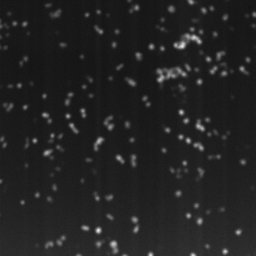

In [6]:
img[:, :, 1, 1]

### Lets use that metadata to index

In [7]:
using AxisArrays

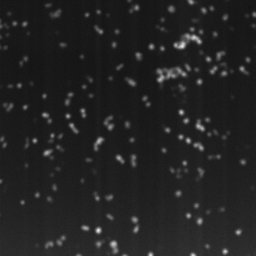

In [8]:
img[Axis{:time}(1), Axis{:position}(1)]

### Cool, but can we get fancier?

Lets grab the 25μm window around the 100th y pixel

In [9]:
using Unitful: ms, μm

v = @view img[Axis{:y}(atindex(-25μm .. 25μm, 100)), 
    Axis{:time}(1), 
    Axis{:position}(1)]

In [10]:
println(summary(v.data))

2-dimensional AxisArray{Gray{N0f16},2,...} with axes:
    :y_sub, (-20.9216:5.2304:20.9216) μm
    :x, (0.0:5.2304:1333.7520000000002) μm
And data, a 9×256 view(reshape(reinterpret(Gray{N0f16}, ::Array{UInt16,6}), 256, 256, 10, 2), [96, 97, 98, 99, 100, 101, 102, 103, 104], :, 1, 1) with eltype Gray{Normed{UInt16,16}}


### Let's try that on the time axis

In [11]:
# lets make a view of all frames between 10s and 20s
view(img, Axis{:time}(10000.0ms .. 20000.0ms), Axis{:position}(:Pos1))

Gray ImageMeta with:
  data: 3-dimensional AxisArray{Gray{N0f16},3,...} with axes:
    :y, (0.0:5.2304:1333.7520000000002) μm
    :x, (0.0:5.2304:1333.7520000000002) μm
    :time, (10000.0:5000.0:20000.0) ms
And data, a 256×256×3 view(reshape(reinterpret(Gray{N0f16}, ::Array{UInt16,6}), 256, 256, 10, 2), :, :, 3:5, 1) with eltype Gray{Normed{UInt16,16}}
  properties:
    Elapsed_Times: Unitful.Quantity{Float64,𝐓,Unitful.FreeUnits{(s,),𝐓,nothing}}[1.348 s 1.891 s; 5.264 s 5.81 s; … ; 40.245 s 40.746 s; 45.243 s 45.721 s]
    Description: 

### Indexing on metadata is basically free

In [12]:
using BenchmarkTools

In [13]:
@btime view(img, :, :, 2, 1);

  31.079 ns (3 allocations: 208 bytes)


In [14]:
@btime view(img, Axis{:time}(5000.0ms), Axis{:position}(:Pos1));

  67.730 ns (4 allocations: 224 bytes)


## Easily write general high performance algorithms

Lets calculate the mean intensity along the time axis for both images that have time axes and those that don't

In [15]:
using ImageAxes, SimpleTraits, Statistics

@traitfn meanintensity(img::AA) where {AA<:AxisArray; !HasTimeAxis{AA}} = mean(img)

@traitfn function meanintensity(img::AA) where {AA<:AxisArray; HasTimeAxis{AA}}
    ax = timeaxis(img)
    n = length(ax)
    intensity = zeros(eltype(img), n)
    for ti in 1:n
        sl = view(img, ax(ti))
        intensity[ti] = mean(sl)
    end
    intensity
end

meanintensity (generic function with 3 methods)

In [16]:
@btime meanintensity(img.data)

  23.799 ms (36 allocations: 2.45 KiB)


In [17]:
slice = view(img, Axis{:time}(1), Axis{:position}(1))
axisnames(slice)

(:y, :x)

In [18]:
@btime meanintensity(slice.data)

  85.822 μs (1 allocation: 16 bytes)


### Lazily map functions across huge images

In [19]:
using ColorSchemes, MappedArrays

From my package [`SegmentationTools.jl`](https://github.com/tlnagy/SegmentationTools.jl)

In [20]:
function colorize_lazy(img; scheme=ColorSchemes.magma)
    mappedarray(x->RGB(get(scheme, gray(x))), img)
end

function colorize(img; scheme=ColorSchemes.magma)
    map(x->RGB(get(scheme, gray(x))), img)
end

colorize (generic function with 1 method)

In [21]:
incolor = @btime colorize(img);

  526.379 ms (11796501 allocations: 390.00 MiB)


In [22]:
incolor2 = @btime colorize_lazy(img);

  1.416 μs (11 allocations: 336 bytes)


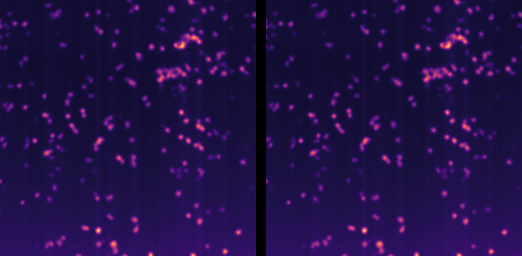

In [23]:
hcat(incolor[:, :, 1, 1], zeros(eltype(incolor), 256, 10), incolor2[:, :, 1, 1])

In [24]:
dump(mappedarray(log, rand(10, 10)), maxdepth=1)

ReadonlyMappedArray{Float64,2,Array{Float64,2},typeof(log)}
  f: log (function of type typeof(log))
  data: Array{Float64}((10, 10)) [0.373269708899971 0.9561345893387105 … 0.26164778779433395 0.7805846491268209; 0.3128743022500271 0.04180932081895539 … 0.09284238474887063 0.2108817772881777; … ; 0.6141624253975786 0.4663319510997117 … 0.8317102303656978 0.227654510576202; 0.45779037106990206 0.9758650441935888 … 0.3304833112532315 0.22856650717890914]


## Summary

- The Julia imaging ecosystem is burgeoning with lots of useful features already

- A joy to develop on top of

- Very powerful fundamentals, but definitely needs more development to complete with the extensiveness of other ecosystems

## Fin

- Thanks to [`Dr Tim Holy`](https://github.com/timholy/) for creating JuliaImages

- Thanks to the Weiner Lab for providing a great work environment

- NSF GRFP and UCSF Discovery Fellowship for funding

### Come help!

- I would love PRs for [`OMETIFF.jl`]("https://github.com/tlnagy/OMETIFF.jl")

- I'm **@tlnagy** on Github 👋